# Xử lý dữ liệu SPADE


In [3]:
import pandas as pd
import numpy as np
import hashlib
import networkx as nx
from collections import Counter, deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import random as rd
import json
import lmstudio as lms

## Tiền xử lý


## Chuyển file đã tiền xử lý sang dạng để sử dụng cho WL subtree

In [4]:

def build_graph_from_spade(events):
    G = nx.DiGraph()

    for entry in events:
        if 'id' in entry:  # là một node
            node_id = entry['id']
            node_type = entry['type']
            label = entry.get('annotations', {}).get('subtype', node_type)
            G.add_node(node_id, label=label)
        else:  # là một edge
            src = entry['from']
            dst = entry['to']
            label = entry['annotations'].get("operation", entry["type"])
            G.add_edge(src, dst, label=label)
            label = "benign"

    labels.append(label)
    return G

with open("log_new.json", "r", encoding="utf-8") as f:
    logs = json.load(f)
labels = []
label = ""
graphs = []
for log in tqdm(logs, desc="Graphs"):
    if(len(log) > 0):
        graphs.append(build_graph_from_spade(log))


Graphs: 100%|██████████| 710/710 [00:08<00:00, 81.57it/s] 


In [ ]:
print(labels)

## FlexSketch
Được trình bày trong bài báo [FlexSketch: Estimation of Probability Density for Stationary and Non-Stationary Data Streams](https://doi.org/10.3390/s21041080).

FlexSketch được sử dụng

In [23]:
class FlexSketch:
    def __init__(self, max_bins=100, max_histograms=5):
        self.max_bins = max_bins
        self.max_histograms = max_histograms
        self.histograms = deque()
        self.weights = deque()

    def update(self, label_counter):
        most_common = label_counter.most_common(self.max_bins)
        vector = np.zeros(self.max_bins)
        for i, (_, count) in enumerate(most_common):
            vector[i] = count
        self.histograms.append(vector)
        self.weights.append(1.0)
        if len(self.histograms) > self.max_histograms:
            self.histograms.popleft()
            self.weights.popleft()
        total_weight = sum(self.weights)
        self.weights = deque([w / total_weight for w in self.weights])

    def estimate_vector(self):
        result = np.zeros(self.max_bins)
        for h, w in zip(self.histograms, self.weights):
            result += w * h
        return result

# WL subtree extraction
def wl_subtree_features(graph, k=2):
    node_labels = nx.get_node_attributes(graph, 'label')
    features = {node: [node_labels.get(node, 'N/A')] for node in graph.nodes()}
    current_labels = node_labels.copy()
    for _ in range(k):
        new_labels = {}
        for node in graph.nodes():
            neighbors = sorted(
                [str(current_labels.get(nbr, '')) for nbr in graph.predecessors(node)] +
                [str(current_labels.get(nbr, '')) for nbr in graph.successors(node)]
            )
            combined = str(current_labels.get(node, '')) + "|" + "|".join(neighbors)
            hash_label = hashlib.md5(combined.encode()).hexdigest()
            new_labels[node] = hash_label
            features[node].append(hash_label)
        current_labels = new_labels
    return features

In [24]:
print("Extracting FlexSketch vectors...")
flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())



Extracting FlexSketch vectors...


Vectorizing: 100%|██████████| 672/672 [00:14<00:00, 45.16it/s] 


Splitting benign and attack samples...
Standardizing feature vectors...
Training KMeans on benign samples...
Computing anomaly threshold...


Benign distances: 100%|██████████| 672/672 [00:00<00:00, 134660.18it/s]


Predicting anomalies...


Predicting: 100%|██████████| 672/672 [00:00<00:00, 121936.94it/s]

Evaluating...



C:\Users\anotherk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anotherk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anotherk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

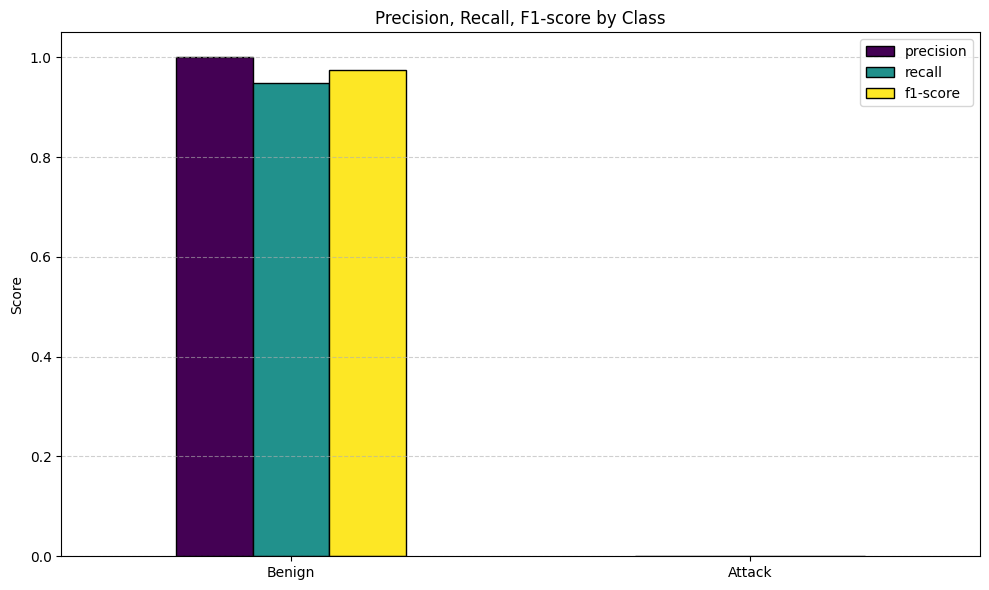


=== Classification Report (Anomaly Detection) ===
{'Benign': {'precision': 1.0, 'recall': 0.9494047619047619, 'f1-score': 0.9740458015267176, 'support': 672.0}, 'Attack': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, 'accuracy': 0.9494047619047619, 'macro avg': {'precision': 0.5, 'recall': 0.47470238095238093, 'f1-score': 0.4870229007633588, 'support': 672.0}, 'weighted avg': {'precision': 1.0, 'recall': 0.9494047619047619, 'f1-score': 0.9740458015267176, 'support': 672.0}}


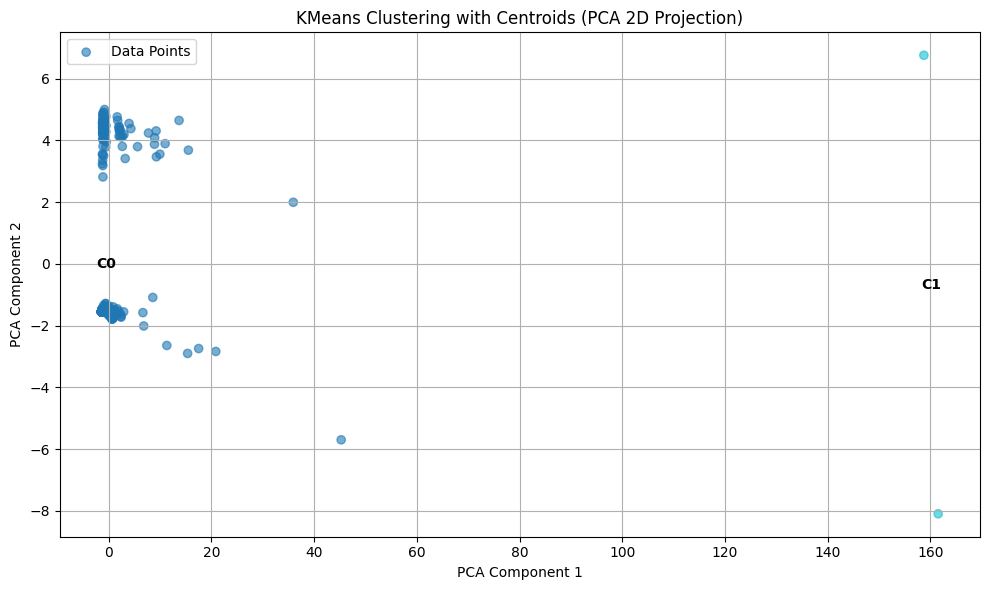

In [25]:
import random

X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
# X_attack = X[y == "attack"]
# X_attack = rd.choices(X_attack, k = 50)
# y_attack = ["attack"] * 50

# X = np.concatenate([X_benign, X_attack], axis=0)
X = np.concatenate([X_benign], axis=0)
# y = ["benign"] * len(labels) + ["attack"] * 50
y = labels
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
#X_attack_scaled = scaler.transform(X_attack)
X_all_scaled = scaler.transform(X)

print("Training KMeans on benign samples...")
kmeans = KMeans(n_clusters=2, random_state=random.randint(1,100))
kmeans.fit(X_benign_scaled)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

print("Computing anomaly threshold...")
benign_dists = [min_distance(x) for x in tqdm(X_benign_scaled, desc="Benign distances")]
threshold = np.percentile(benign_dists, 95)

with open("threshold_spade.json", "w") as f:
    json.dump({"threshold": threshold}, f)

print("Predicting anomalies...")
all_labels = [1 if cls == "attack" else 0 for cls in y]
pred_labels = [1 if min_distance(x) > threshold else 0 for x in tqdm(X_all_scaled, desc="Predicting")]

print("Evaluating...")
report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filter only Benign, Attack
plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]

# Plot
ax = plot_data.plot(kind="bar", figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

model_path = "kmeans_model_spade.joblib"
scaler_path = "scaler_spade.joblib"

joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

print("\n=== Classification Report (Anomaly Detection) ===")
print(report)
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Predict cluster labels for visualization
cluster_labels = kmeans.predict(X_all_scaled)

# Plot clusters with centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, label="Data Points")
#plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label="Centroids")

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'C{i}', fontsize=10, ha='center', va='center', weight='bold', color='black')

plt.title("KMeans Clustering with Centroids (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Thử nghiệm trên input thực tế

In [ ]:

print(threshold)
logs = []
with open("log.json", "r", encoding="utf-8") as f:
    logs = json.load(f)

graphs = []
graphs.append(build_graph_from_spade(logs))

flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())

total = 0

def detect(x):
    global total
    dist = min_distance(x)
    print(dist)
    total += dist
    print(threshold)
    return dist > threshold

X = np.array(flex_vectors)
y = np.array(labels)
Xscale = scaler.transform(X)
for G in Xscale:

    if detect(G):
        print("attack")

    else:
        print("benign")


print(total / len(flex_vectors))



In [ ]:
def graph_to_text(graph: nx.DiGraph) -> str:
    lines = []
    for src, dst, data in graph.edges(data=True):
        src_label = graph.nodes[src].get('label', 'Unknown')
        dst_label = graph.nodes[dst].get('label', 'Unknown')
        op = data.get('label', data.get('operation', 'access'))
        lines.append(f"{src} ({src_label}) --[{op}]--> {dst} ({dst_label})")
    return "\n".join(lines)

def llm_analyze_graph(graph: nx.DiGraph):
    model = lms.llm("qwen3-30b-a3b")
    prompt = f"""
You are a cybersecurity analyst. Analyze the following provenance graph for possible APT-style attack behavior.

Each line represents a system-level event:

{graph_to_text(graph)}

Please explain what the behavior indicates. Is this malicious? Why or why not? What kind of attack might it be?
"""
    response = model.respond(prompt)
    return response
print(graph_to_text(graphs[0]))